## Задача

***Описание проекта:***
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

## Предподготовка данных

In [1]:
!pip install lightgbm

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

In [4]:
df = pd.read_csv("C://Users/Владислав/Desktop/Новая папка/Data sceince/Проект численные методы/autos.csv")
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
((df.isna().sum())/df.shape[0]).sort_values(ascending=False)

Repaired             0.200791
VehicleType          0.105794
FuelType             0.092827
Gearbox              0.055967
Model                0.055606
DateCrawled          0.000000
Price                0.000000
RegistrationYear     0.000000
Power                0.000000
Kilometer            0.000000
RegistrationMonth    0.000000
Brand                0.000000
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

Наибольшее количество пропусков (2%) в информации о наличии дтп у автомобилей. 1% пропусков в информации о типе кузова и типе двигателя. Учитывая объем данных такое количество пропусков не критично для обучения

Посмотрим на распределение данных

In [7]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Есть некоторые аномалии в виде выбросов цены, мощности и некорректных дат выпуска авто. Рассмотрим подробнее и исправим

C:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Распределение значений стоимости автомобиля')

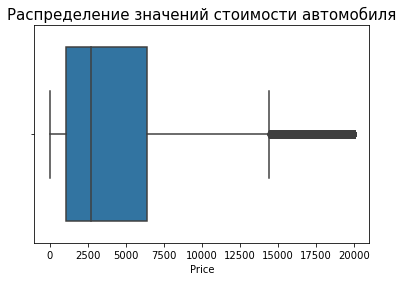

In [8]:
sns.boxplot(df['Price']) 
plt.title('Распределение значений стоимости автомобиля', fontsize=15)

Сделаем срез, отбросив выбросы по цене

In [9]:
df = df[(df["Price"]>=100)] 
type(df)

pandas.core.frame.DataFrame

In [10]:
np.sort(df["RegistrationYear"].unique())
type(df)

pandas.core.frame.DataFrame

Отбросим все записи об авто, выпущенных до 1910 и после 2016 годов, т.к. это явные ошибки

In [11]:
df = df[(df["RegistrationYear"]>=1910)&(df["RegistrationYear"]<=2016)]
type(df)

pandas.core.frame.DataFrame

Посмотрим выбровы по мощности

C:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Распределение значений мощности автомобиля')

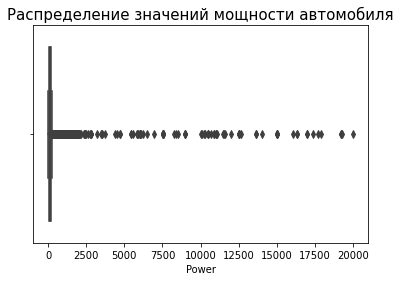

In [12]:
sns.boxplot(df['Power']) 
#type(df)
plt.title('Распределение значений мощности автомобиля', fontsize=15)

Все, что выше 500 (лс или кВт) явно лишнее



In [13]:
df = df[(df["Power"]<500)]
type(df)

pandas.core.frame.DataFrame

Нулевые значения в столбце мощности заменим медианными знаениями

In [14]:
median_power = df['Power'].median()
print(median_power)
print(type(df))

105.0
<class 'pandas.core.frame.DataFrame'>


In [15]:
df.loc[df['Power'] == 0, 'Power'] = median_power

Удалим столбцы, которые не будут участвовать в обучении

In [16]:
df = df.drop(['DateCrawled','DateCreated','LastSeen','NumberOfPictures', 'PostalCode', 'RegistrationMonth'], axis=1)

In [17]:
df.isna().sum()

Price                   0
VehicleType         18867
RegistrationYear        0
Gearbox             14580
Power                   0
Model               15124
Kilometer               0
FuelType            23041
Brand                   0
Repaired            58294
dtype: int64

Заменим пропещенные категориальные данные наиболее часто встречающимися в каждой категории:

In [19]:
col_for_rep = ['VehicleType', 'Gearbox', 'Model', 'FuelType','Repaired']
for i in col_for_rep:
    df[i] = df[i].fillna(df[i].mode()[0]) #[0] нужно потому, что df.mode() возвращает значение и индекс, те Series, а данная запись даст строку


In [20]:
df.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

In [21]:
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,sedan,1993,manual,105,golf,150000,petrol,volkswagen,no
1,18300,coupe,2011,manual,190,golf,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354363,1150,bus,2000,manual,105,zafira,150000,petrol,opel,no
354365,2200,sedan,2005,manual,105,golf,20000,petrol,sonstige_autos,no
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


## Подготовка данных

In [22]:
df_ohe = pd.get_dummies(df, drop_first=True)

features = df_ohe.drop(['Price'], axis = 1)  
target = df_ohe['Price'] 

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=888)

<div class="alert alert-warning">
<b>Комментарий ревьюера:
⚠</b> Для OHE лучше использовать OneHotEncoder и только после разделения на выборки, т.к. get_dummies не вставить в пайплайны + могут быть ошибки в кодировании. При кодировании get_dummies после разбиения выборки придётся проверять, что получились одинаковые признаки и в одинаковом порядке(можно использовать конструкцию <code>final_train, final_test = train.align(test, join='inner', axis=1)</code> для приведения признаков к единому виду. OneHotEncoder может работать со значениями признака, которого не было в тестовой выборке, можно использовать в column_transformer, пайплайнах и т.д. Пример использования <a href = "https://colab.research.google.com/drive/1_gAMXcQKoCShB_l8FNtYEejMnosm9mvt?usp=sharing">OHE</a>. Так же без разделения выборки до кодирования возникает утечка в данных
</div>

## Обучение


#### LinearRegression

In [43]:
%%time
model_LR = LinearRegression()
#model.fit(features_train, target_train)
scores_LR = cross_val_score(model_LR, features_train, target_train, scoring='neg_root_mean_squared_error')

CPU times: total: 46 s
Wall time: 26.2 s


In [44]:
scores_LR.mean()

-2699.093767613106

Rmse линейной регресси не удовлетваряет тербованим заказчика, по этому исключим ее из дальнейшего рассмотрения

#### LightGBM

Проанализаируем LGBMRegressor с параметрами "по умолчанию"

In [59]:
%%time

model_lgbm = LGBMRegressor()
scores_lgbm = cross_val_score(model_lgbm, features_train, target_train, scoring='neg_root_mean_squared_error')

CPU times: total: 34.6 s
Wall time: 13.1 s


In [46]:
scores_lgbm.mean()

-1725.3490459159307

Оценим скорость обучения и скорость пердсказания

In [53]:
%%time
model_lgbm.fit(features_train, target_train)

CPU times: total: 6.56 s
Wall time: 2.5 s


LGBMRegressor()

In [57]:
%%time
predicted_lgbm = model_lgbm.predict(features_train)

CPU times: total: 3.38 s
Wall time: 1.48 s


Подберем параметры для LGBMRegressor через grid search

In [39]:
%%time

model_lgbm = LGBMRegressor()

grid_space = {
    'n_estimators': [8,16,32,64,128,256],
    'max_depth': [3,9,18,27]
}

grid = GridSearchCV(model_lgbm,param_grid=grid_space,cv=3,scoring='neg_root_mean_squared_error')
model_grid = grid.fit(features_train, target_train)

print('Лучшие параметры:', model_grid.best_params_)
print('Rmse:', model_grid.best_score_)

Лучшие параметры: {'max_depth': 27, 'n_estimators': 256}
Rmse: -1656.347843871756
CPU times: total: 7min 9s
Wall time: 3min 52s


Время подбора значительно увелисилось. Получив лучшую комбинацию параметров проведем обучение модели на обучающей выборке, а за тем предсказание на тестовой

In [49]:
%%time
model_lgbm_final = LGBMRegressor(max_depth=27, n_estimators=256)
model_lgbm_final.fit(features_train, target_train)


CPU times: total: 10.6 s
Wall time: 3.65 s


LGBMRegressor(max_depth=27, n_estimators=256)

In [58]:
%%time
predicted_lgbm_final = model_lgbm_final.predict(features_train)

CPU times: total: 5.98 s
Wall time: 2.06 s


Время обучения с готовым набором параметров чуть больше, в сравнении с параметрами "по умолчанию". Результат немного выше. Предсказание тоже чуть дольше. Не смотря на это т.к. rmse у этой модели меньше остальных, именно ее протестируем в финале на тестовой выборке

In [51]:
%%time
predict_lbgm_final = model_lgbm_final.predict(features_test)
mean_squared_error(target_test, predict_lbgm_final)**0.5

CPU times: total: 2.06 s
Wall time: 704 ms


1637.0801553234433

LGBMRegressor(max_depth=27, n_estimators=256) показала отличный результат на тестовой выборке. 2 секунды на предсказание и 1637 rmse.

### Вывод:

В рамках проекта была потавлена задача разработать модель обучения, которая предскажет рыночную стоимость автомобиля по данным, о предыдущих родажах. Рассмотрены 2 модели: LinearRegressor и LGBMRegressor. При этом LGBMRegressor протестирован по умолчанию, с применением поиска по сетке и случайного поиска гиперпараметров.

Модель LinearRegressor показала неудовлетварительный результат. Все остальны показали результаты, отвечающие условиям заказчика: RMSE<2500. 

LinearRegressor добилась результата rmse 2699 за 46 сек. на обучающей выборке.  

LGBMRegressor по умолчанию показала rmse 1725 за 6.65 сек. на обучение и 3.38 на предсказание на обучающей выборке.

Подбор гиперпарамеров через GridSearchCV на обучающей выбоке учлучшил rmse до 1656 затратив 10.6 сек. на обучение и 5.56с на предсказание.

LGBMRegressor с подобранными через GridSearchCV параметрами max_depth=27 и n_estimators=256 протестировали на тестовой выборке. Она показала отличный результат: 2 секунды на предсказание и 1637 rmse.

Запуск случайного поиска занимает титаническое количссетво времени. 

Оптимальным для этой задачи в рамказ рассмотренных моделей считаю LGBMRegressor с гиперпараметрами  max_depth=27 и n_estimators=256.